In [1]:
import numpy as np
from numpy import random
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.metrics import confusion_matrix
from sklearn.linear_model import SGDClassifier

### Logistic Regression

In the 6.0 notebook, we learned that the model for multi-linear regression has the form $f(X) = \beta_0+\beta_1X_1+\beta_2X_2+...+\beta_nX_n$ which can be written as 

$$f(X) = \theta^TX$$ where $\theta = \begin{pmatrix}
    \beta_0 \\
    \beta_1 \\
    \vdots \\
    \beta_n \\
\end{pmatrix}$ and $X = \begin{pmatrix}
    1 \\
    X_1 \\
    \vdots \\
    X_n \\
\end{pmatrix}$.  This is an example of a *regression* model: given a row $x_i=(x_{i1}, x_{i2},...,x_{in},y_i)$ in our dataset, linear regression gives a numerical prediction $\hat{y}_i$ for the actual value $y_i$.

*Logistic Regression* is an example of a *classification* model: given a row $x_i=(x_{i1}, x_{i2},...,x_{in},y_i =0$ or $1)$ in our dataset, logistic regression gives a probability $\hat{y}_i$ that $y_i = 1$.

The model for logistic regression has the form $f(X) = \frac{1}{1+e^{-(\beta_0+\beta_1X_1+\beta_2X_2+...+\beta_nX_n)}}$ which can be written more compactly as 

$$f(X) = \frac{1}{1+e^{-\theta^TX}}$$ where $\theta = \begin{pmatrix}
    \beta_0 \\
    \beta_1 \\
    \vdots \\
    \beta_n \\
\end{pmatrix}$ and $X = \begin{pmatrix}
    1 \\
    X_1 \\
    \vdots \\
    X_n \\
\end{pmatrix}$.

The thing to notice here is that $f(X)$ can be written as a *composition*:

$$f(X) = (\frac{1}{1+e^{-x}}) \circ (\theta^TX)$$

The function $y = \frac{1}{1+e^{-x}}$ is called the *sigmoid* function and is commonly denoted $\sigma(x) = \frac{1}{1+e^{-x}}$.  The graph of $\sigma(x)$ is given below.

In [2]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

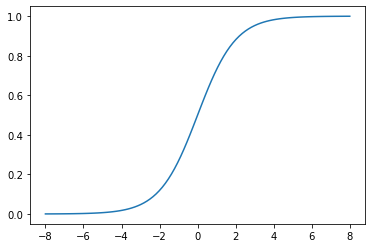

In [3]:
Xs = np.linspace(-8, 8, num = 100)
plt.plot(Xs, np.array([sigmoid(x) for x in Xs]))

$\sigma(x)$ basically forces $\theta^TX = \beta_0+\beta_1X_1+\beta_2X_2+...+\beta_nX_n$ to be a probability since $0 \leq \sigma(\theta^TX) \leq 1$.

#### Loss Function

The loss function for logistic regression is the *binary cross entropy* loss function given below.

$$L_{BCE} = -\frac{1}{N}\sum_{i=1}^N (y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i))$$

**Derivation**: Given a row in the dataset $x_i=(x_{i1}, x_{i2},...,x_{in},y_i)$, the output of logistic regression $f(x_i)=\hat{y}_i$ is the probability that $y_i$ is 1.  We can think of this probability $\hat{y}_i$ as the *conditional probability* $P(y_i=1|x_i) = \hat{y}_i$.  

This probability can be expressed as 

$$P(y=1|x) = \hat{y}^y(1-\hat{y})^{1-y}$$

where we have removed the subscripts for clarity.  This makes sense since $y = y_i = 0$ or $1$.

If $y = 0$, then $P(y=1|x) = \hat{y}^y(1-\hat{y})^{1-y} = \hat{y}^0(1-\hat{y})^{1-0} = 1\cdot (1-\hat{y})^1 = (1-\hat{y}) =$ the probability that $y \neq 1$.

If $y = 1$, then $P(y=1|x) = \hat{y}^y(1-\hat{y})^{1-y} = \hat{y}^1(1-\hat{y})^{1-1} = \hat{y}\cdot (1-\hat{y})^0 = \hat{y}\cdot 1 = \hat{y} =$ the probability that $y = 1$.

Now, if we were to take all of these expressions $\hat{y}^y(1-\hat{y})^{1-y}$ for each of the $N$ rows in our dataset, sum them up, and divide by $N$ to get 

$$L_{Incorrect} = \frac{1}{N}\sum_{i=1}^N \hat{y}^y(1-\hat{y})^{1-y} \text{,}$$

this function would do *exactly the opposite* of what we want it to do.  We want a loss function to output low values for correct classifications and output high values for incorrect classifications.  However, $\hat{y}^y(1-\hat{y})^{1-y}$ is big when the classification is correct and small when the classification is incorrect.

We could try negating the terms to get the function 

$$L_{Incorrect} = -\frac{1}{N}\sum_{i=1}^N \hat{y}^y(1-\hat{y})^{1-y} \text{,}$$

but this doesn't work either, since this function is always negative. To fix this, we take the $-\log(x)$ to get  

$-\log(P(y=1|x))$

$ = -\log(\hat{y}^y(1-\hat{y})^{1-y})$

$ = -(\log(\hat{y}^y)+\log((1-\hat{y})^{1-y}))$

$ = -(y\log(\hat{y})+(1-y)\log(1-\hat{y})$.

This works, since $0\leq P(y=1|x) \leq 1 \Rightarrow -\log(P(y=1|x))\geq 0$ and $-\log(x)$ is a one-to-one function.

Now, taking all of these expressions $-(y\log(\hat{y})+(1-y)\log(1-\hat{y})$ for each of the $N$ rows in our dataset, summing them up, and dividing by $N$ we get the binary cross entropy loss function

$$L_{BCE} = -\frac{1}{N}\sum_{i=1}^N (y_i\log(\hat{y}_i)+(1-y_i)\log(1-\hat{y}_i))$$

##### Example 1

We create a logistic regression model for the Social Network Ads dataset.  The goal is to predict if a user purchased and add or not.

In [2]:
data = pd.read_csv('Social_Network_Ads.csv')

In [3]:
data.head()

,User ID,Gender,Age,EstimatedSalary,Purchased
0,15624510,Male,19,19000,0
1,15810944,Male,35,20000,0
2,15668575,Female,26,43000,0
3,15603246,Female,27,57000,0
4,15804002,Male,19,76000,0


In [4]:
data = data.drop(columns = ['User ID'])

In [5]:
data.head()

,Gender,Age,EstimatedSalary,Purchased
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


In [6]:
data = data.rename(columns = {'Gender':'gender', 'Age':'age', 'EstimatedSalary':'salary', 'Purchased':'y'})

In [7]:
data.head()

,gender,age,salary,y
0,Male,19,19000,0
1,Male,35,20000,0
2,Female,26,43000,0
3,Female,27,57000,0
4,Male,19,76000,0


##### Feature Scaling

In [8]:
cols_to_scale = ['age', 'salary']

In [9]:
scaler=StandardScaler()
data[cols_to_scale] = scaler.fit_transform(data[cols_to_scale])

In [10]:
data[cols_to_scale].mean()

age      -2.331468e-16
salary   -1.193490e-17
dtype: float64

In [11]:
data[cols_to_scale].std()

age       1.001252
salary    1.001252
dtype: float64

##### Encode Categorical Data

In [12]:
data['gender'] = data.gender.apply(lambda x: 1 if x == 'Male' else 0)

In [13]:
data.head()

,gender,age,salary,y
0,1,-1.781797,-1.490046,0
1,1,-0.253587,-1.460681,0
2,0,-1.113206,-0.785290,0
3,0,-1.017692,-0.374182,0
4,1,-1.781797,0.183751,0


##### Baseline

In [14]:
data['y'].value_counts()

0    257
1    143
Name: y, dtype: int64

In [15]:
(data['y']==0).sum()/data.shape[0]

0.6425

##### Create the Model

In [16]:
X = data.iloc[:, :-1].to_numpy()
y = data.iloc[:, -1:].to_numpy().ravel()

In [17]:
X_train,X_test,y_train,y_test=train_test_split(X, y, test_size=0.25, random_state=250)

We use Sci-Kit Learn's SGDClassifier class.  Documentation can be found [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html#sklearn.linear_model.SGDClassifier).

The SGD stands for Stochastic Gradient Descent.

Many parameters are passed to the instantiation of our SGDClassifier object below.  

Parameters explained:
+ loss = 'log_loss': this specifies which loss function to use.  When using 'log_loss' SGDClassifier is a logistic regression model.
+ penalty = None: this specifies which type of regularization to use.  We will cover regularization later in the class.
+ max_iter = 1000: this specifies the number of times that the entire training set is used (epoch).
+ tol = 1e-3: tolerance used for gradient descent.
+ learning_rate = 'constant': learning rate for gradient descent.  If set to 'constant', then the learning rate does not change throughout gradient descent.  Other options are specified in the documentation.
+ eta0 = 0.01: the initial learning rate.  If learning_rate = 'constant', this is the learning rate.  

In [32]:
model = SGDClassifier(loss = 'log_loss', penalty = None, max_iter = 1000, tol = 1e-3, learning_rate = 'constant', eta0 = 0.01) 

In [33]:
model.fit(X_train,y_train)

SGDClassifier(eta0=0.01, learning_rate='constant', loss='log_loss',
              penalty=None)

In [34]:
y_pred = model.predict(X_test)

In [35]:
confusion_matrix(y_test, y_pred)

array([[50,  8],
       [ 8, 34]], dtype=int64)

In [36]:
#Use H. Indexing to make look nice
tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()

In [37]:
tn, fp, fn, tp

(50, 8, 8, 34)

##### Accuracy

Accuracy $= \frac{TP+TN}{TP+TN+FP+FN}$

In [38]:
(tp+tn)/(tp+tn+fp+fn)

0.84

Another way to compute this using NumPy arrays is given below.

In [39]:
(y_pred==y_test).sum()/len(y_pred)

0.84

##### Precision

Precision $= \frac{TP}{TP+FP}$

In [40]:
tp/(tp+fp)

0.8095238095238095

In [41]:
fp

8

##### Recall

Recall $= \frac{TP}{TP+FN}$

In [42]:
tp/(tp+fn)

0.8095238095238095

In [43]:
fn

8

$\Box$

##### Example 2

Re-run Example 1 but do not do scaling and see how the model does.